In [94]:
from rfgap import RFGAP
from sklearn.model_selection import train_test_split
from dataset import dataprep


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the data and normalize

In [95]:
# TODO: Test with NumPy and Pandas, ALL METHODS and perhaps combos of each type. Problem with categorical data in Pandas?
# We should probably modify RFGAP to handle categorical data in the form of strings.

In [96]:
seed = 42
prox_method = 'rfgap'
force_symmetric = False
non_zero_diagonal = False
batch_size = 50
oob_score = True
verbose=True
test_size=0.2
n_jobs = -1

data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/iris.csv')
x, y   = dataprep(data)

n_samples = x.shape[0]
n_features = x.shape[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(f"Train samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")
print(f"Number of features: {x_train.shape[1]}")

Train samples: 120, Test samples: 30
Number of features: 4


## Train the RF Model

In [97]:
rf = RFGAP(y = y_train, prox_method = prox_method, matrix_type = 'sparse', oob_score = True, non_zero_diagonal = non_zero_diagonal,
           random_state = seed, n_jobs = n_jobs, force_symmetric = force_symmetric, verbose=verbose, batch_size=batch_size)

In [98]:
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


## Generate the Proximity Matrix

In [99]:
# compute/get proximity matrix and visualize with seaborn heatmap
prox = rf.get_proximities()

[get_proximities] AutoBatch B=50, n_rows=120, batches=3
[get_proximities] 1/3 rows 0→50
[get_proximities] 2/3 rows 50→100
[get_proximities] 3/3 rows 100→120


# Visualize it

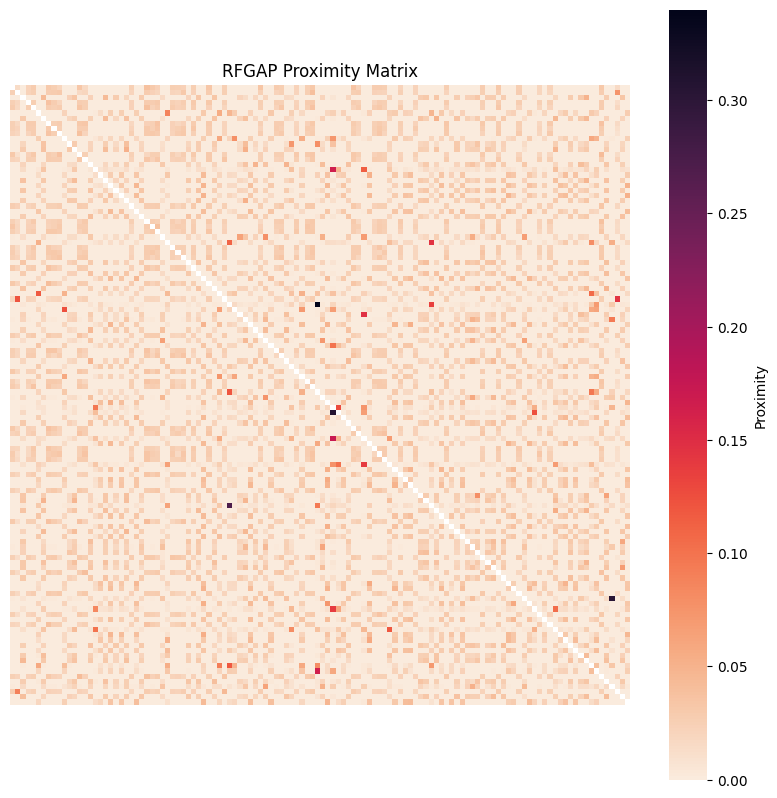

In [100]:
prox_mat = prox.toarray()

# mask diagonal to emphasize off-diagonal proximities
mask = np.eye(prox_mat.shape[0], dtype=bool)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(prox_mat, ax=ax, cmap='rocket_r', vmin=0, vmax=prox_mat.max(), mask=mask,
            xticklabels=False, yticklabels=False, square=True, cbar_kws={'label': 'Proximity'})
ax.set_title(f'{prox_method.upper()} Proximity Matrix')
plt.show()

## Check extended proximity computation using a training subset

In [101]:
rf.prox_extend(x_test, [1,4,77,80]).toarray()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


[prox_extend] AutoBatch B=50, n_rows=30, batches=1
[prox_extend] 1/1 rows 0→30


array([[0.        , 0.        , 0.        , 0.4642857 ],
       [0.46130952, 0.38392857, 0.        , 0.        ],
       [0.        , 0.        , 0.44047618, 0.        ],
       [0.        , 0.        , 0.        , 0.4642857 ],
       [0.        , 0.        , 0.01190476, 0.2857143 ],
       [0.3065476 , 0.5029762 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.44047618],
       [0.        , 0.        , 0.4642857 , 0.        ],
       [0.        , 0.        , 0.        , 0.4047619 ],
       [0.        , 0.        , 0.        , 0.42857143],
       [0.        , 0.        , 0.48809522, 0.        ],
       [0.29464287, 0.49107143, 0.        , 0.        ],
       [0.38988096, 0.4077381 , 0.        , 0.02380952],
       [0.29464287, 0.5029762 , 0.        , 0.        ],
       [0.29464287, 0.5029762 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.44047618],
       [0.        , 0.        , 0.53571427, 0.        ],
       [0.        , 0.        ,

## Check Sum-to-One

In [102]:
# check row sums (should sum to 1)
row_sums = np.sum(prox.toarray(), axis=1)

print("rows:", row_sums.shape[0])
print("min, max, mean:", row_sums.min(), row_sums.max(), row_sums.mean())

tol_r, tol_a = 1e-5, 1e-8
close_mask = np.isclose(row_sums, 1.0, rtol=tol_r, atol=tol_a)
print(f"rows ~1 within rtol={tol_r}, atol={tol_a}: {np.count_nonzero(close_mask)}/{len(row_sums)}")

bad_idx = np.where(~close_mask)[0]
if bad_idx.size:
    print("Example rows not summing to ~1 (index, sum):")
    for i in bad_idx[:10]:
        print(i, row_sums[i])
else:
    print("All rows sum approximately to 1.")

rows: 120
min, max, mean: 0.99999994 1.0 1.0
rows ~1 within rtol=1e-05, atol=1e-08: 120/120
All rows sum approximately to 1.


## Measures of Trust

### RF-ICE (Trust Scores)

In [103]:
ice_scores = rf.get_instance_classification_expectation()
print(rf.trust_auc)

[get_proximities] AutoBatch B=50, n_rows=120, batches=3
[get_proximities] 1/3 rows 0→50
[get_proximities] 2/3 rows 50→100
[get_proximities] 3/3 rows 100→120
0.9844370268980636


#### Accuracy Rejection Curve

Text(0.5, 1.0, 'Scatter Plot of Training Data with 1 - Trust Scores')

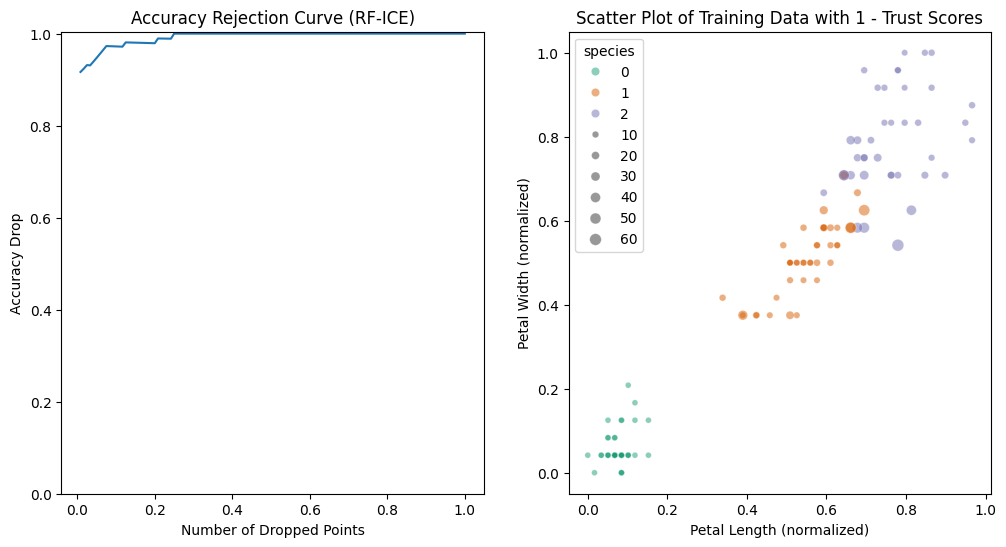

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(x=rf.trust_n_drop, y=rf.trust_accuracy_drop, ax=ax[0])
ax[0].set_xlabel('Number of Dropped Points')
ax[0].set_ylabel('Accuracy Drop')
ax[0].set_title('Accuracy Rejection Curve (RF-ICE)')
ax[0].set_ylim(0, None)

sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train, palette='Dark2',
                size=(np.max(rf.trust_scores) - rf.trust_scores) * 100 + 5, alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Scatter Plot of Training Data with 1 - Trust Scores')


### RF-ICE for Test Set

In [105]:
trust_scores_test = rf.get_test_trust(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


[prox_extend] AutoBatch B=50, n_rows=30, batches=1
[prox_extend] 1/1 rows 0→30


Text(0.5, 1.0, 'Test Data with 1 - Trust Scores')

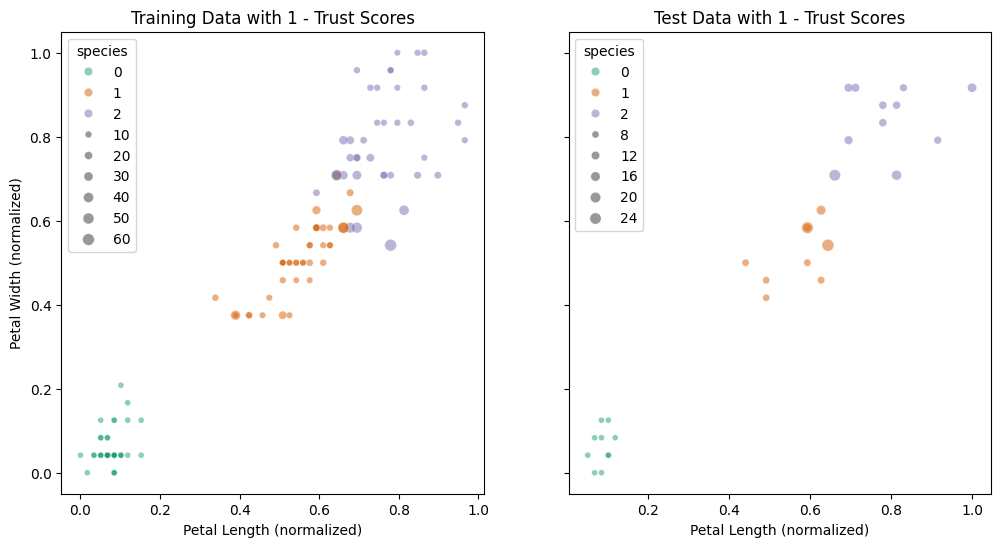

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train, palette='Dark2',
                size=(np.max(rf.trust_scores) - rf.trust_scores) * 100 + 5, alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Petal Length (normalized)')
ax[0].set_ylabel('Petal Width (normalized)')
ax[0].set_title('Training Data with 1 - Trust Scores')

sns.scatterplot(x=x_test[:, 2], y=x_test[:, 3], hue=y_test, palette='Dark2',
                size=(np.max(rf.trust_scores_test) - rf.trust_scores_test) * 100 + 5, alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Test Data with 1 - Trust Scores')

In [107]:
rf.get_nonconformity(k = 5, x_test = x_test, proximity_type = 'rfgap')

[get_proximities] AutoBatch B=50, n_rows=120, batches=3
[get_proximities] 1/3 rows 0→50
[get_proximities] 2/3 rows 50→100
[get_proximities] 3/3 rows 100→120
[prox_extend] AutoBatch B=50, n_rows=30, batches=1
[prox_extend] 1/1 rows 0→30


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [108]:
rf.test_proximities.shape

(30, 120)

Text(0.5, 1.0, 'Scatter Plot of Training Data with Nonconformity Scores')

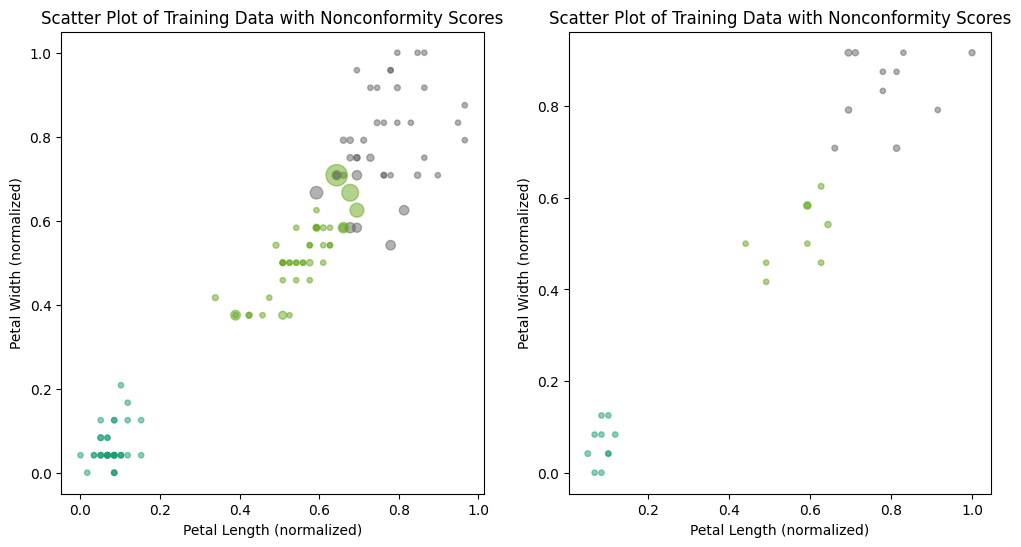

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


ax[0].scatter(x_train[:, 2], x_train[:, 3], c=y_train, cmap='Dark2', 
            s=rf.nonconformity_scores * 20 + 15, alpha=0.5)
ax[0].set_xlabel('Petal Length (normalized)')
ax[0].set_ylabel('Petal Width (normalized)')
ax[0].set_title('Scatter Plot of Training Data with Nonconformity Scores')


ax[1].scatter(x_test[:, 2], x_test[:, 3], c = y_test, cmap='Dark2', 
            s=rf.nonconformity_scores_test * 20 + 15, alpha=0.5)
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Scatter Plot of Training Data with Nonconformity Scores')

Text(0.5, 1.0, 'Conformity Accuracy Rejection Curve')

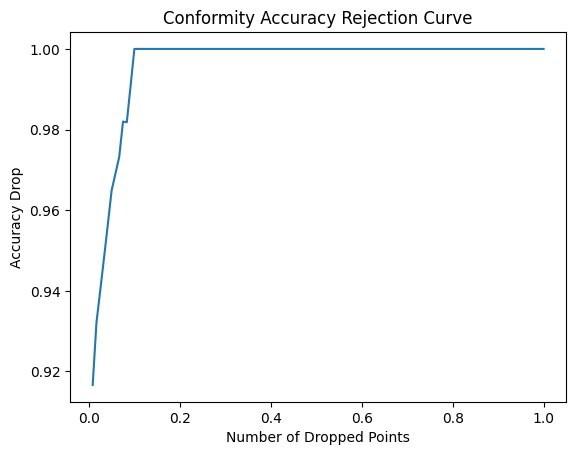

In [110]:
sns.lineplot(x=rf.conformity_n_drop, y=rf.conformity_accuracy_drop)
plt.xlabel('Number of Dropped Points')
plt.ylabel('Accuracy Drop')
plt.title('Conformity Accuracy Rejection Curve')

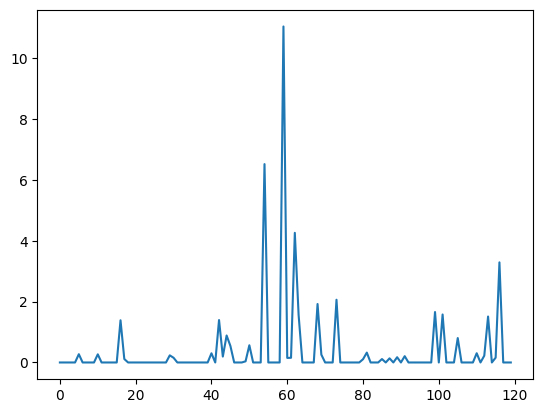

In [111]:
plt.plot(rf.nonconformity_scores)

In [112]:
                # Updates the following attributes:
                # - `self.nonconformity_scores`
                # - `self.conformity_scores`
                # - `self.conformity_quantiles`
                # - `self.conformity_auc`
                # - `self.conformity_accuracy_drop`
                # - `self.conformity_n_drop`
                
                # If `x_test` is provided, also updates:
                # - `self.nonconformity_scores_test`
                # - `self.conformity_scores_test`
                # - `self.conformity_quantiles_test`